::: {.callout-note collapse="false"}
## Learning Outcomes
* Derive the optimal model parameters for the constant model under MSE and MAE cost functions.
* Evaluate the differences between MSE and MAE risk.
* Understand the need for linearization of variables and apply the Tukey-Mosteller bulge diagram for transformations.
:::

Last time, we introduced the modeling process. We set up a framework to predict target variables as functions of our features, following a set workflow:

1. Choose a model - how should we represent the world? 
2. Choose a loss function - how do we quantify prediction error? 
3. Fit the model - how do we choose the best parameter of our model given our data? 
4. Evaluate model performance - how do we evaluate whether this process gave rise to a good model? 

To illustrate this process, we derived the optimal model parameters under simple linear regression (SLR) with mean squared error (MSE) as the cost function. A summary of the SLR modeling process is shown below: 

<div align="middle">
<img src="images/slr_modeling_process.png" alt='error' width='600'>
</div>

In this lecture, we'll dive deeper into step 4 - evaluating model performance - using SLR as an example. Additionally, we'll also explore the modeling process with new models, continue familiarizing ourselves with the modeling process by finding the best model parameters under a new model, the constant model, and test out two different loss functions to understand how our choice of loss influences model design. Later on, we'll consider what happens when a linear model isn't the best choice to capture trends in our data and what solutions there are to create better models.

## Step 4: Evaluating the SLR Model
Now that we've explored the mathematics behind (1) choosing a model, (2) choosing a loss function, and (3) fitting the model, we're left with one final question – how "good" are the predictions made by this "best" fitted model? To determine this, we can: 

1. Visualize data and compute statistics: 
    * Plot the original data.
    * Compute each column's mean and standard deviation. If the mean and standard deviation of our predictions are close to those of the original observed $y_i$s, we might be inclined to say that our model has done well.
    * (If we're fitting a linear model) compute the correlation $r$. A large magnitude for the correlation coefficient between the feature and response variables could also indicate that our model has done well.
2. Performance metrics: 
    * We can take the **root mean squared error (RMSE)**.
        * It's the square root of the mean squared error (MSE), which is the average loss that we've been minimizing to determine optimal model parameters.
        * RMSE is in the same units as $y$.
        * A lower RMSE indicates more "accurate" predictions, as we have a lower "average loss" across the data.

    $$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$$
        
3. Visualization: 
    * Look at the residual plot of $e_i = y_i - \hat{y_i}$ to visualize the difference between actual and predicted values.

To illustrate this process, let's take a look at **Anscombe's quartet**. 

### Four Mysterious Datasets (Anscombe’s quartet)
Let's take look at four different datasets. 

In [5]:
#| code-fold: true
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from mpl_toolkits.mplot3d import Axes3D

In [6]:
#| code-fold: true
# Big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Helper functions
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    return np.mean(standard_units(x) * standard_units(y))

def slope(x, y):
    return correlation(x, y) * np.std(y) / np.std(x)

def intercept(x, y):
    return np.mean(y) - slope(x, y)*np.mean(x)

def fit_least_squares(x, y):
    theta_0 = intercept(x, y)
    theta_1 = slope(x, y)
    return theta_0, theta_1

def predict(x, theta_0, theta_1):
    return theta_0 + theta_1*x

def compute_mse(y, yhat):
    return np.mean((y - yhat)**2)

plt.style.use('default') # Revert style to default mpl

In [9]:
plt.style.use('default') # Revert style to default mpl
NO_VIZ, RESID, RESID_SCATTER = range(3)
def least_squares_evaluation(x, y, visualize=NO_VIZ):
    # statistics
    print(f"x_mean : {np.mean(x):.2f}, y_mean : {np.mean(y):.2f}")
    print(f"x_stdev: {np.std(x):.2f}, y_stdev: {np.std(y):.2f}")
    print(f"r = Correlation(x, y): {correlation(x, y):.3f}")
    
    # Performance metrics
    ahat, bhat = fit_least_squares(x, y)
    yhat = predict(x, ahat, bhat)
    print(f"\theta_0: {ahat:.2f}, \theta_1: {bhat:.2f}")
    print(f"RMSE: {np.sqrt(compute_mse(y, yhat)):.3f}")

    # visualization
    fig, ax_resid = None, None
    if visualize == RESID_SCATTER:
        fig, axs = plt.subplots(1,2,figsize=(8, 3))
        axs[0].scatter(x, y)
        axs[0].plot(x, yhat)
        axs[0].set_title("LS fit")
        ax_resid = axs[1]
    elif visualize == RESID:
        fig = plt.figure(figsize=(4, 3))
        ax_resid = plt.gca()
    
    if ax_resid is not None:
        ax_resid.scatter(x, y - yhat, color = 'red')
        ax_resid.plot([4, 14], [0, 0], color = 'black')
        ax_resid.set_title("Residuals")
    
    return fig

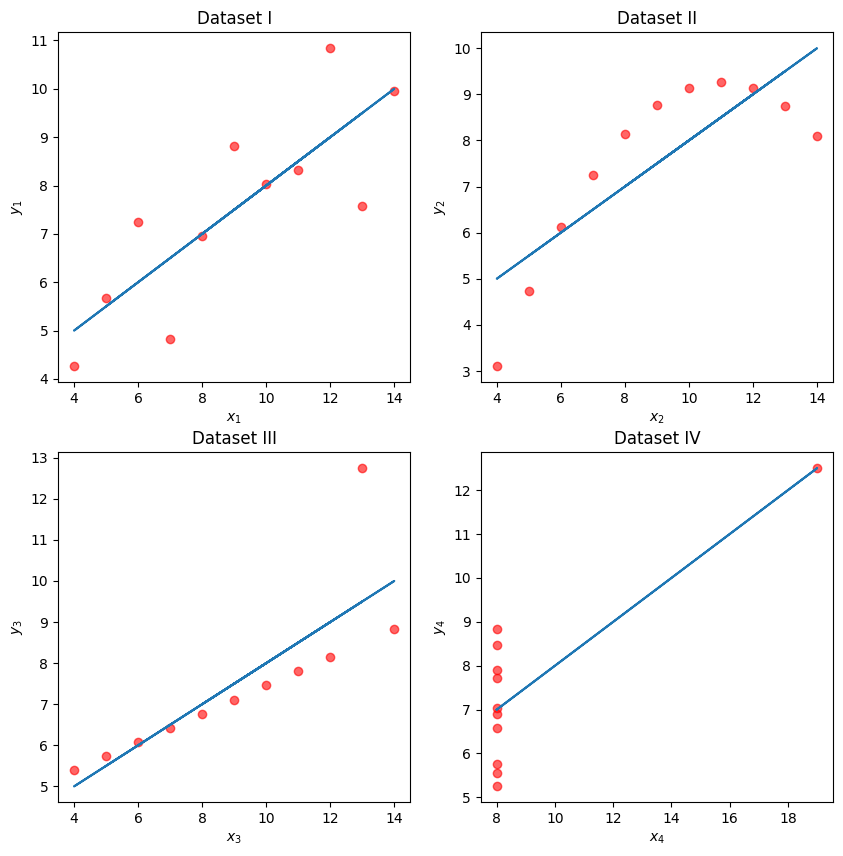

In [10]:
#| code-fold: true
# Load in four different datasets: I, II, III, IV
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

anscombe = {
    'I': pd.DataFrame(list(zip(x, y1)), columns =['x', 'y']),
    'II': pd.DataFrame(list(zip(x, y2)), columns =['x', 'y']),
    'III': pd.DataFrame(list(zip(x, y3)), columns =['x', 'y']),
    'IV': pd.DataFrame(list(zip(x4, y4)), columns =['x', 'y'])
}

# Plot the scatter plot and line of best fit 
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

for i, dataset in enumerate(['I', 'II', 'III', 'IV']):
    ans = anscombe[dataset]
    x, y  = ans['x'], ans['y']
    ahat, bhat = fit_least_squares(x, y)
    yhat = predict(x, ahat, bhat)
    axs[i//2, i%2].scatter(x, y, alpha=0.6, color='red') # plot the x, y points
    axs[i//2, i%2].plot(x, yhat) # plot the line of best fit 
    axs[i//2, i%2].set_xlabel(f'$x_{i+1}$')
    axs[i//2, i%2].set_ylabel(f'$y_{i+1}$')
    axs[i//2, i%2].set_title(f"Dataset {dataset}")

plt.show()

While these four sets of datapoints look very different, they actually all have identical $\bar x$, $\bar y$, $\sigma_x$, $\sigma_y$, correlation $r$, and RMSE! If we only look at these statistics, we would probably be inclined to say that these datasets are similar.

In [11]:
#| code-fold: true
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize = NO_VIZ)
    print()
    print()

>>> Dataset I:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
	heta_0: 3.00, 	heta_1: 0.50
RMSE: 1.119


>>> Dataset II:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
	heta_0: 3.00, 	heta_1: 0.50
RMSE: 1.119


>>> Dataset III:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
	heta_0: 3.00, 	heta_1: 0.50
RMSE: 1.118


>>> Dataset IV:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.817
	heta_0: 3.00, 	heta_1: 0.50
RMSE: 1.118




We may also wish to visualize the model's **residuals**, defined as the difference between the observed and predicted $y_i$ value ($e_i = y_i - \hat{y}_i$). This gives a high-level view of how "off" each prediction is from the true observed value. Recall that you explored this concept in [Data 8](https://inferentialthinking.com/chapters/15/5/Visual_Diagnostics.html?highlight=heteroscedasticity#detecting-heteroscedasticity): a good regression fit should display no clear pattern in its plot of residuals. The residual plots for Anscombe's quartet are displayed below. Note how only the first plot shows no clear pattern to the magnitude of residuals. This is an indication that SLR is not the best choice of model for the remaining three sets of points.

<!-- <img src="images/residual.png" alt='residual' width='600'> -->


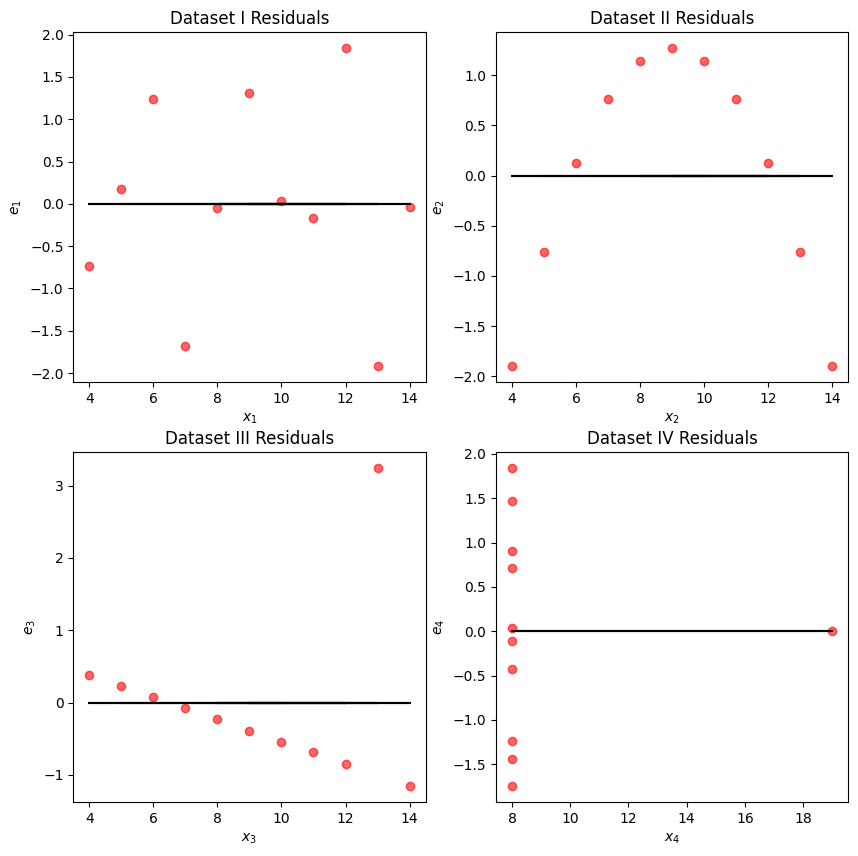

In [12]:
#| code-fold: true
# residual visualization
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

for i, dataset in enumerate(['I', 'II', 'III', 'IV']):
    ans = anscombe[dataset]
    x, y  = ans['x'], ans['y']
    ahat, bhat = fit_least_squares(x, y)
    yhat = predict(x, ahat, bhat)
    axs[i//2, i%2].scatter(x, y - yhat, alpha=0.6, color='red') # plot the x, y points
    axs[i//2, i%2].plot(x, np.zeros_like(x), color='black') # plot the residual line
    axs[i//2, i%2].set_xlabel(f'$x_{i+1}$')
    axs[i//2, i%2].set_ylabel(f'$e_{i+1}$')
    axs[i//2, i%2].set_title(f"Dataset {dataset} Residuals")

plt.show()

### Prediction vs. Estimation
The terms prediction and estimation are often used somewhat interchangeably, but there is a subtle difference between them. **Estimation** is the task of using data to calculate model parameters. **Prediction** is the task of using a model to predict outputs for unseen data. In our simple linear regression model 

$$\hat{y} = \hat{\theta_0} + \hat{\theta_1}$$

we **estimate** the parameters by minimizing average loss; then, we **predict** using these estimations. **Least Squares Estimation** is when we choose the parameters that minimize MSE.

## Constant Model + MSE

Now, we'll shift from the SLR model to the **constant model**, also known as a summary statistic. The constant model is slightly different from the simple linear regression model we've explored previously. Rather than generating predictions from an inputted feature variable, the constant model always *predicts the same constant number*. This ignores any relationships between variables. For example, let's say we want to predict the number of drinks a boba shop sells in a day. Boba tea sales likely depend on the time of year, the weather, how the customers feel, whether school is in session, etc., but the constant model ignores these factors in favor of a simpler model. In other words, the constant model employs a **simplifying assumption**. 

It is also a parametric, statistical model:

$$\hat{y}_i = \theta_0$$

$\theta_0$ is the parameter of the constant model, just as $\theta_0$ and $\theta_1$ were the parameters in SLR. 
Since our parameter $\theta_0$ is 1-dimensional ($\theta_0 \in \mathbb{R}$), we now have no input to our model and will always predict $\hat{y}_i = \theta_0$.

### Deriving the optimal $\theta_0$
Our task now is to determine what value of $\theta_0$ best represents the optimal model – in other words, what number should we guess each time to have the lowest possible **average loss** on our data?

Like before, we'll use Mean Squared Error (MSE). Recall that the MSE is average squared loss (L2 loss) over the data $D = \{y_1, y_2, ..., y_n\}$.

$$R(\theta) = \frac{1}{n}\sum^{n}_{i=1} (y_i - \hat{y_i})^2 $$

Our modeling process now looks like this: 

1. Choose a model: constant model
2. Choose a loss function: L2 loss
3. Fit the model
4. Evaluate model performance


Given the **constant model** $\hat{y}_i = \theta_0$, we can rewrite the MSE equation as 

$$R(\theta) = \frac{1}{n}\sum^{n}_{i=1} (y_i - \theta_0)^2 $$

We can fit **the model** by finding the optimal $\theta_0$ that minimizes the MSE using a calculus approach. 

1. Differentiate with respect to $\theta_0$

$$
\begin{align}
\frac{d}{d\theta_0}\text{R}(\theta) & = \frac{d}{d\theta_0}\frac{1}{n}\sum^{n}_{i=1} (y_i - \theta_0)^2
\\ &= {n}\sum^{n}_{i=1} \frac{d}{d\theta_0}  (y_i - \theta_0)^2 \quad \quad \text{derivative of sum is a sum of derivatives}
\\ &= {n}\sum^{n}_{i=1} 2 (y_i - \theta_0) (-1) \quad \quad \text{chain rule}
\\ &= {\frac{-2}{n}}\sum^{n}_{i=1} (y_i - \theta_0) \quad \quad \text{simply constants}
\end{align}
$$

2. Set equal to 0
$$
0 = {\frac{-2}{n}}\sum^{n}_{i=1} (y_i - \theta_0)
$$

3. Solve for $\theta_0$

$$
\begin{align}
0 &= {\frac{-2}{n}}\sum^{n}_{i=1} (y_i - \theta_0)
\\ &= \sum^{n}_{i=1} (y_i - \theta_0) \quad \quad \text{divide both sides by} \frac{-2}{n} 
\\ &= \sum^{n}_{i=1} y_i - \sum^{n}_{i=1} \theta_0 \quad \quad \text{separate sums}
\\ &= \sum^{n}_{i=1} y_i - n * \theta_0 \quad \quad  \text{c + c + … + c = nc}
\\ n * \theta_0 &= \sum^{n}_{i=1} y_i 
\\ \theta_0 &= \frac{1}{n} \sum^{n}_{i=1} y_i 
\\ \theta_0 &= \bar{y}
\end{align}
$$

Let's take a moment to interpret this result. $\hat{\theta} = \bar{y}$ is the optimal parameter for constant model + MSE.
It holds true regardless of what data sample you have, and it provides some formal reasoning as to why the mean is such a common summary statistic.

Our optimal model parameter is the value of the parameter that minimizes the cost function. This minimum value of the cost function can be expressed:

$$R(\hat{\theta}) = \min_{\theta} R(\theta)$$

To restate the above in plain English: we are looking at the value of the cost function when it takes the best parameter as input. This optimal model parameter, $\hat{\theta}$, is the value of $\theta$ that minimizes the cost $R$.

For modeling purposes, we care less about the minimum value of cost, $R(\hat{\theta})$, and more about the *value of $\theta$* that results in this lowest average loss. In other words, we concern ourselves with finding the best parameter value such that:

$$\hat{\theta} = \underset{\theta}{\operatorname{\arg\min}}\:R(\theta)$$

That is, we want to find the **arg**ument $\theta$ that **min**imizes the cost function.

### Comparing Two Different Models, Both Fit with MSE
Now that we've explored the constant model with an L2 loss, we can compare it to the SLR model that we learned last lecture. Consider the dataset below, which contains information about the ages and lengths of dugongs. Supposed we wanted to predict dugong ages:

| |  Constant Model | Simple Linear Regression |
| -- | -------------- | ------------------------ |
| model | $\hat{y} = \theta_0$ | $\hat{y} = \theta_0 + \theta1 x$ |
| data | sample of ages $D = \{y_1, y_2, ..., y_m\}$ | sample of ages $D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$ |
| dimensions | $\hat{\theta_0}$ is 1-D | $\hat{\theta} = [\hat{\theta_0}, \hat{\theta_1}]$ is 2-D |
| loss surface | 2-D ![](images/constant_loss_surface.png) | 3-D ![](images/slr_loss_surface.png) | 
| Loss Model | $\hat{R}(\theta) = \frac{1}{n}\sum^{n}_{i=1} (y_i - \theta_0)^2$ | $\hat{R}(\theta) = \frac{1}{n}\sum^{n}_{i=1} (y_i - (\theta_0 + \theta_1 x))^2$ |
| RMSE | 7.72 | 4.31 |
| predictions visualized | rug plot ![](images/dugong_rug.png) | scatter plot ![](images/dugong_scatter.png)|

(Notice how the points for our SLR scatter plot are visually not a great linear fit. We'll come back to this).

The code for generating the graphs and models is included below, but we won't go over it in too much depth.

In [14]:
#| code-fold: true
dugongs = pd.read_csv("data/dugongs.csv")
data_constant = dugongs["Age"]
data_linear = dugongs[["Length", "Age"]]

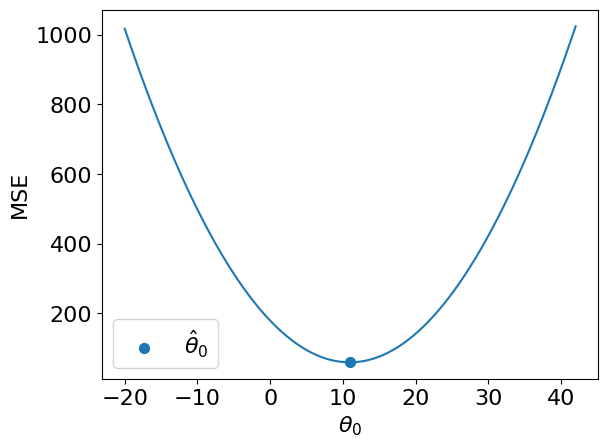

In [15]:
#| code-fold: true
# Constant Model + MSE
plt.style.use('default') # Revert style to default mpl
adjust_fontsize(size=16)
%matplotlib inline

def mse_constant(theta, data):
    return np.mean(np.array([(y_obs - theta) ** 2 for y_obs in data]), axis=0)

thetas = np.linspace(-20, 42, 1000)
l2_loss_thetas = mse_constant(thetas, data_constant)

# plotting the loss surface
plt.plot(thetas, l2_loss_thetas)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'MSE')

# Optimal point
thetahat = np.mean(data_constant)
plt.scatter([thetahat], [mse_constant(thetahat, data_constant)], s=50, label = r"$\hat{\theta}_0$")
plt.legend()
# plt.show()

Text(0.5, 0, 'MSE')

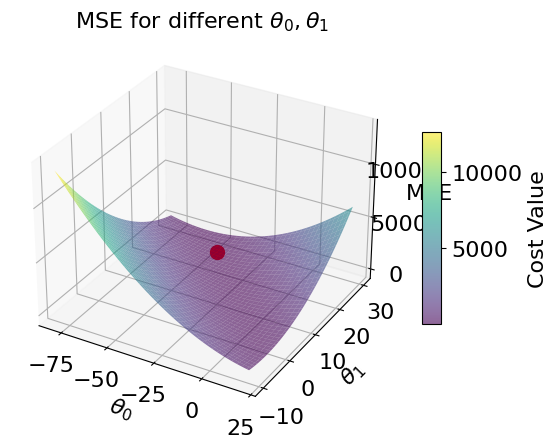

In [16]:
#| code-fold: true
# SLR + MSE
def mse_linear(theta_0, theta_1, data_linear):
    data_x, data_y = data_linear.iloc[:,0], data_linear.iloc[:,1]
    return np.mean(np.array([(y - (theta_0+theta_1*x)) ** 2 for x, y in zip(data_x, data_y)]), axis=0)

# plotting the loss surface
theta_0_values = np.linspace(-80, 20, 80)
theta_1_values = np.linspace(-10, 30, 80)
mse_values = np.array([[mse_linear(x,y,data_linear) for x in theta_0_values] for y in theta_1_values])

# Optimal point
data_x, data_y = data_linear.iloc[:, 0], data_linear.iloc[:, 1]
theta_1_hat = np.corrcoef(data_x, data_y)[0, 1] * np.std(data_y) / np.std(data_x)
theta_0_hat = np.mean(data_y) - theta_1_hat * np.mean(data_x)

# Create the 3D plot
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(theta_0_values, theta_1_values)
surf = ax.plot_surface(X, Y, mse_values, cmap='viridis', alpha=0.6)  # Use alpha to make it slightly transparent

# Scatter point using matplotlib
sc = ax.scatter([theta_0_hat], [theta_1_hat], [mse_linear(theta_0_hat, theta_1_hat, data_linear)],
                marker='o', color='red', s=100, label='theta hat')

# Create a colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Cost Value')

ax.set_title('MSE for different $\\theta_0, \\theta_1$')
ax.set_xlabel('$\\theta_0$')
ax.set_ylabel('$\\theta_1$') 
ax.set_zlabel('MSE')

# plt.show()

In [17]:
#| code-fold: true
# predictions
yobs = data_linear["Age"]      # The true observations y
xs = data_linear["Length"]     # Needed for linear predictions
n = len(yobs)                  # Predictions

yhats_constant = [thetahat for i in range(n)]    # Not used, but food for thought
yhats_linear = [theta_0_hat + theta_1_hat * x for x in xs]

([], [])

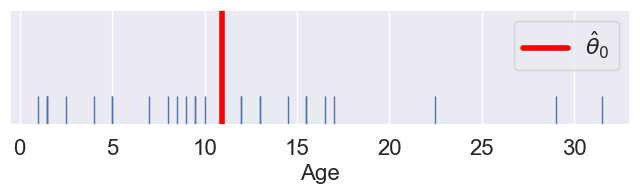

In [18]:
#| code-fold: true
# Constant Model Rug Plot
# In case we're in a weird style state
sns.set_theme()
adjust_fontsize(size=16)
%matplotlib inline

fig = plt.figure(figsize=(8, 1.5))
sns.rugplot(yobs, height=0.25, lw=2) ;
plt.axvline(thetahat, color='red', lw=4, label=r"$\hat{\theta}_0$");
plt.legend()
plt.yticks([])
# plt.show()

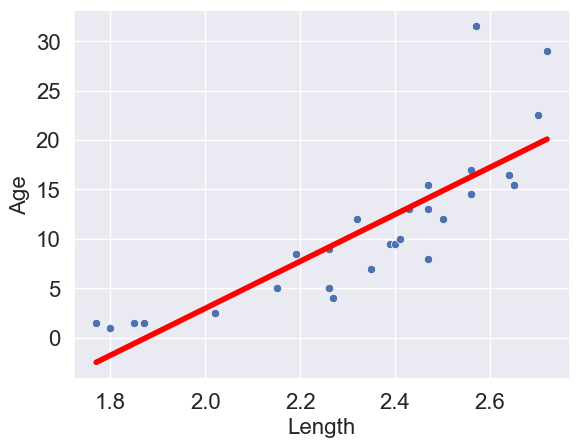

In [19]:
#| code-fold: true
# SLR model scatter plot 
# In case we're in a weird style state
sns.set_theme()
adjust_fontsize(size=16)
%matplotlib inline

sns.scatterplot(x=xs, y=yobs)
plt.plot(xs, yhats_linear, color='red', lw=4)
# plt.savefig('dugong_line.png', bbox_inches = 'tight');
# plt.show()

Interpreting the RMSE (Root Mean Squared Error):
* The constant error is HIGHER than the linear error.

Hence,
* The constant model is WORSE than the linear model (at least for this metric).

## Constant Model + MAE 

We see now that changing the model used for prediction leads to a wildly different result for the optimal model parameter. What happens if we instead change the loss function used in model evaluation?

This time, we will consider the constant model with L1 (absolute loss) as the loss function. This means that the average loss will be expressed as the **Mean Absolute Error (MAE)**. 

1. Choose a model: constant model
2. Choose a loss function: L1 loss
3. Fit the model
4. Evaluate model performance

### Deriving the optimal $\theta_0$

Recall that the MAE is average **absolute** loss (L1 loss) over the data $D = \{y_1, y_2, ..., y_m\}$.

$$\hat{R}(\theta) = \frac{1}{n}\sum^{n}_{i=1} |y_i - \hat{y_i}| $$

Given the constant model $\hat{y} = \theta_0$, we can write the MAE as:

$$\hat{R}(\theta) = \frac{1}{n}\sum^{n}_{i=1} |y_i - \theta_0| $$

To fit the model, we find the optimal parameter value $\hat{\theta}$ by differentiating using a calculus approach:

1. Differentiate with respect to $\hat{\theta_0}$.

$$\hat{R}(\theta) = \frac{1}{n}\sum^{n}_{i=1} |y_i - \theta| $$

$$\frac{d}{d\theta} R(\theta) = \frac{d}{d\theta} \left(\frac{1}{n} \sum^{n}_{i=1} |y_i - \theta| \right)$$

$$= \frac{1}{n} \sum^{n}_{i=1} \frac{d}{d\theta} |y_i - \theta|
$$

* Here, we seem to have run into a problem: the derivative of an absolute value is undefined when the argument is 0 (i.e. when $y_i = \theta$). For now, we'll ignore this issue. It turns out that disregarding this case doesn't influence our final result.
* To perform the derivative, consider two cases. When $\theta$ is *less than or equal to* $y_i$, the term $y_i - \theta$ will be positive and the absolute value has no impact. When $\theta$ is *greater than* $y_i$, the term $y_i - \theta$ will be negative. Applying the absolute value will convert this to a positive value, which we can express by saying $-(y_i - \theta) = \theta - y_i$. 

$$|y_i - \theta| = \begin{cases} y_i - \theta \quad \text{ if } \theta \le y_i \\ \theta - y_i \quad \text{if }\theta > y_i \end{cases}$$

* Taking derivatives:

$$\frac{d}{d\theta} |y_i - \theta| = \begin{cases} \frac{d}{d\theta} (y_i - \theta) = -1 \quad \text{if }\theta < y_i \\ \frac{d}{d\theta} (\theta - y_i) = 1 \quad \text{if }\theta > y_i \end{cases}$$

* This means that we obtain a different value for the derivative for data points where $\theta < y_i$ and where $\theta > y_i$. We can summarize this by saying:

$$\frac{d}{d\theta} R(\theta) = \frac{1}{n} \sum^{n}_{i=1} \frac{d}{d\theta} |y_i - \theta| \\
= \frac{1}{n} \left[\sum_{\hat{\theta_0} < y_i} (-1) + \sum_{\hat{\theta_0} > y_i} (+1) \right]
$$

* In other words, we take the sum of values for $i = 1, 2, ..., n$:
    * $-1$ if our observation $y_i$ is *greater than* our prediction $\hat{\theta_0}$
    * $+1$ if our observation $y_i$ is *smaller than* our prediction $\hat{\theta_0}$

2. Set equal to 0. 
$$ 0 = \frac{1}{n}\sum_{\hat{\theta_0} < y_i} (-1) + \frac{1}{n}\sum_{\hat{\theta_0} > y_i} (+1) $$

3. Solve for $\hat{\theta_0}$.
$$ 0 = -\frac{1}{n}\sum_{\hat{\theta_0} < y_i} (1) + \frac{1}{n}\sum_{\hat{\theta_0} > y_i} (1)$$

$$\sum_{\hat{\theta_0} < y_i} (1) = \sum_{\hat{\theta_0} > y_i} (1) $$

Thus, the constant model parameter $\theta = \hat{\theta_0}$ that minimizes MAE must satisfy:

$$ \sum_{\hat{\theta_0} < y_i} (1) = \sum_{\hat{\theta_0} > y_i} (1) $$

In other words, the number of observations greater than $\theta_0$ must be equal to the number of observations less than $\theta_0$; there must be an equal number of points on the left and right sides of the equation. This is the definition of median, so our optimal value is 
$$ \hat{\theta_0} = median(y) $$

## Summary: Loss Optimization, Calculus, and Critical Points
First, define the **objective function** as average loss.

* Plug in L1 or L2 loss.
* Plug in the model so that the resulting expression is a function of $\theta$.

Then, find the minimum of the objective function:

1. Differentiate with respect to $\theta$.
2. Set equal to 0.
3. Solve for $\hat{\theta}$.
4. (If we have multiple parameters) repeat steps 1-3 with partial derivatives.

Recall critical points from calculus: $R(\hat{\theta})$ could be a minimum, maximum, or saddle point!
* We should technically also perform the second derivative test, i.e., show $R''(\hat{\theta}) > 0$.
* MSE has a property—**convexity**—that guarantees that $R(\hat{\theta})$ is a global minimum.
* The proof of convexity for MAE is beyond this course.



## Comparing Loss Functions

We've now tried our hand at fitting a model under both MSE and MAE cost functions. How do the two results compare?

Let's consider a dataset where each entry represents the number of drinks sold at a bubble tea store each day. We'll fit a constant model to predict the number of drinks that will be sold tomorrow.

In [20]:
#| code-fold: false
drinks = np.array([20, 21, 22, 29, 33])
drinks

array([20, 21, 22, 29, 33])

From our derivations above, we know that the optimal model parameter under MSE cost is the mean of the dataset. Under MAE cost, the optimal parameter is the median of the dataset. 

In [21]:
#| code-fold: false
np.mean(drinks), np.median(drinks)

(25.0, 22.0)

If we plot each empirical risk function across several possible values of $\theta$, we find that each $\hat{\theta}$ does indeed correspond to the lowest value of error:

<img src="images/error.png" alt='error' width='600'>

Notice that the MSE above is a **smooth** function – it is differentiable at all points, making it easy to minimize using numerical methods. The MAE, in contrast, is not differentiable at each of its "kinks." We'll explore how the smoothness of the cost function can impact our ability to apply numerical optimization in a few weeks. 

How do outliers affect each cost function? Imagine we replace the largest value in the dataset with 1000. The mean of the data increases substantially, while the median is nearly unaffected.

In [22]:
#| code-fold: false
drinks_with_outlier = np.append(drinks, 1000)
display(drinks_with_outlier)
np.mean(drinks_with_outlier), np.median(drinks_with_outlier)

array([  20,   21,   22,   29,   33, 1000])

(187.5, 25.5)

This means that under the MSE, the optimal model parameter $\hat{\theta}$ is strongly affected by the presence of outliers. Under the MAE, the optimal parameter is not as influenced by outlying data. We can generalize this by saying that the MSE is **sensitive** to outliers, while the MAE is **robust** to outliers.

Let's try another experiment. This time, we'll add an additional, non-outlying datapoint to the data.

In [23]:
#| code-fold: false
drinks_with_additional_observation = np.append(drinks, 35)
drinks_with_additional_observation

array([20, 21, 22, 29, 33, 35])

When we again visualize the cost functions, we find that the MAE now plots a horizontal line between 22 and 29. This means that there are *infinitely* many optimal values for the model parameter: any value $\hat{\theta} \in [22, 29]$ will minimize the MAE. In contrast, the MSE still has a single best value for $\hat{\theta}$. In other words, the MSE has a **unique** solution for $\hat{\theta}$; the MAE is not guaranteed to have a single unique solution.

<img src="images/compare_loss.png" alt='compare_loss' width='600'>

To summarize our example, 

| -- | MSE (Mean Squared Loss) | MAE (Mean Absolute Loss) | 
| -- | -- | -- | 
| Loss Function | $\hat{R}(\theta) = \frac{1}{n}\sum^{n}_{i=1} (y_i - \theta_0)^2$ | $\hat{R}(\theta) = \frac{1}{n}\sum^{n}_{i=1} |y_i - \theta_0|$ |
| optimal $\hat{\theta_0}$ | $\hat{\theta_0} = mean(y) = \bar{y}$ | $\hat{\theta_0} = median(y)$ |
| loss surface | ![](images/mse_loss.png) | ![](images/mae_loss.png) | 
| shape | **Smooth** - easy to minimize using numerical methods (in a few weeks) | **Piecewise** - at each of the “kinks,” it’s not differentiable. Harder to minimize. | 
| outliers | **Sensitive** to outliers (since they change mean substantially). Sensitivity also depends on the dataset size. | **More robust** to outliers. | 
| $\hat{\theta_0}$ uniqueness | **unique** $\hat{\theta_0}$ | **Infinitely many** $\hat{\theta_0}$ | 

## Transformations to fit Linear Models

At this point, we have an effective method of fitting models to predict linear relationships. Given a feature variable and target, we can apply our four-step process to find the optimal model parameters. 

A key word above is *linear*. When we computed parameter estimates earlier, we assumed that $x_i$ and $y_i$ shared a roughly linear relationship. Data in the real world isn't always so straightforward, but we can transform the data to try and obtain linearity.

The **Tukey-Mosteller Bulge Diagram** is a useful tool for summarizing what transformations can linearize the relationship between two variables. To determine what transformations might be appropriate, trace the shape of the "bulge" made by your data. Find the quadrant of the diagram that matches this bulge. The transformations shown on the vertical and horizontal axes of this quadrant can help improve the fit between the variables.

<img src="images/bulge.png" alt='bulge' width='600'>

Note that: 
* There are multiple solutions. Some will fit better than others. 
* sqrt and log make a value “smaller.”
* Raising to a power makes a value “bigger.”
* Each of these transformations equates to increasing or decreasing the scale of an axis.

Other goals in addition to linearity are possible, for example, making data appear more symmetric.
Linearity allows us to fit lines to the transformed data.

Let's revisit our dugongs example. The lengths and ages are plotted below: 

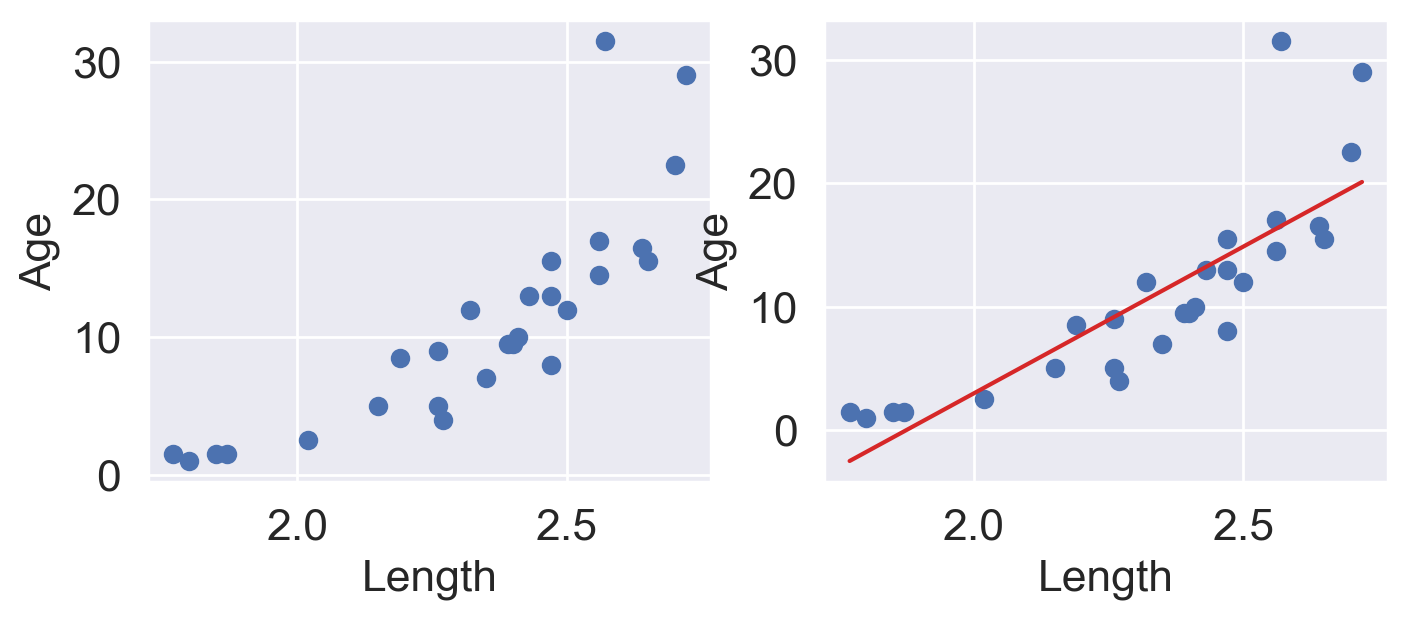

In [28]:
#| code-fold: true
# `corrcoef` computes the correlation coefficient between two variables
# `std` finds the standard deviation
x = dugongs["Length"]
y = dugongs["Age"]
r = np.corrcoef(x, y)[0, 1]
theta_1 = r*np.std(y)/np.std(x)
theta_0 = np.mean(y) - theta_1*np.mean(x)

fig, ax = plt.subplots(1, 2, dpi=200, figsize=(8, 3))
ax[0].scatter(x, y)
ax[0].set_xlabel("Length")
ax[0].set_ylabel("Age")

ax[1].scatter(x, y)
ax[1].plot(x, theta_0 + theta_1*x, "tab:red")
ax[1].set_xlabel("Length")
ax[1].set_ylabel("Age");

Looking at the plot on the left, we see that there is a slight curvature to the data points. Plotting the SLR curve on the right results in a poor fit.

For SLR to perform well, we'd like there to be a rough linear trend relating `"Age"` and `"Length"`. What is making the raw data deviate from a linear relationship? Notice that the data points with `"Length"` greater than 2.6 have disproportionately high values of `"Age"` relative to the rest of the data. If we could manipulate these data points to have lower `"Age"` values, we'd "shift" these points downwards and reduce the curvature in the data. Applying a logarithmic transformation to $y_i$ (that is, taking $\log($ `"Age"` $)$ ) would achieve just that.

An important word on $\log$: in Data 100 (and most upper-division STEM courses), $\log$ denotes the natural logarithm with base $e$. The base-10 logarithm, where relevant, is indicated by $\log_{10}$.

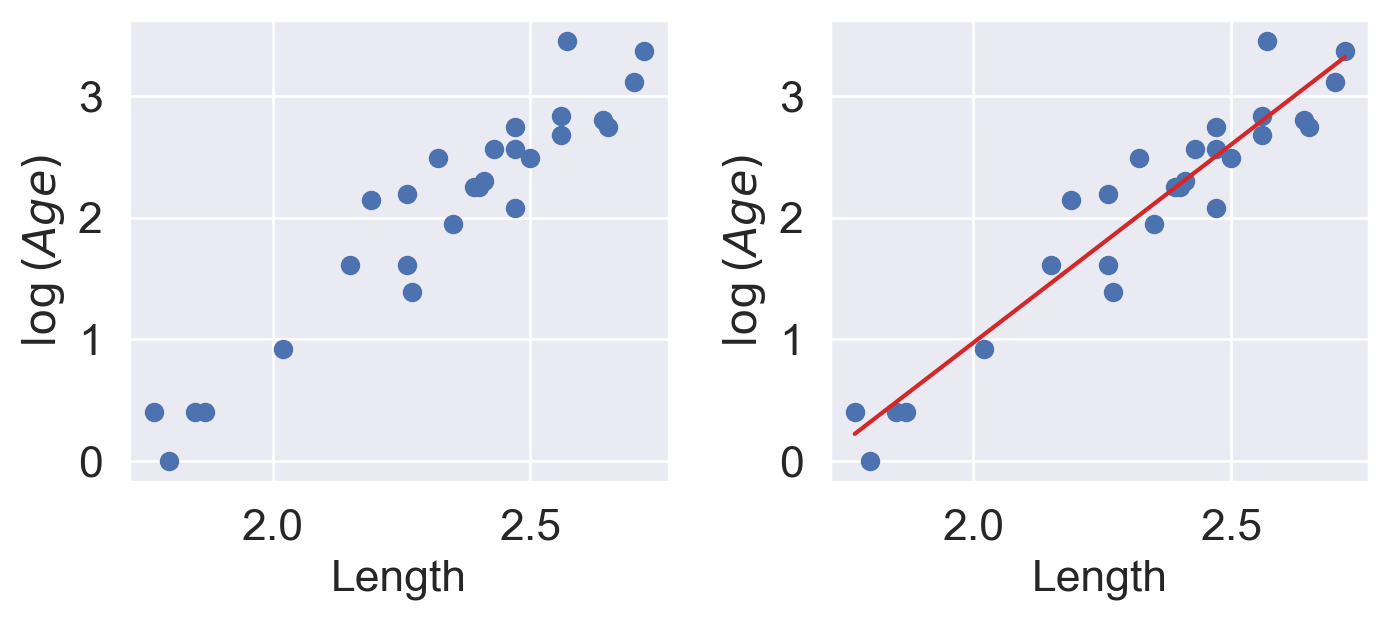

In [29]:
#| code-fold: true
z = np.log(y)

r = np.corrcoef(x, z)[0, 1]
theta_1 = r*np.std(z)/np.std(x)
theta_0 = np.mean(z) - theta_1*np.mean(x)

fig, ax = plt.subplots(1, 2, dpi=200, figsize=(8, 3))
ax[0].scatter(x, z)
ax[0].set_xlabel("Length")
ax[0].set_ylabel(r"$\log{(Age)}$")

ax[1].scatter(x, z)
ax[1].plot(x, theta_0 + theta_1*x, "tab:red")
ax[1].set_xlabel("Length")
ax[1].set_ylabel(r"$\log{(Age)}$")

plt.subplots_adjust(wspace=0.3);

Our SLR fit looks a lot better! We now have a new target variable: the SLR model is now trying to predict the *log* of `"Age"`, rather than the untransformed `"Age"`. In other words, we are applying the transformation $z_i = \log{(y_i)}$. Notice that the resulting model is still **linear in the parameters** $\theta = [\theta_0, \theta_1]$. The SLR model becomes:

$$\log{\hat{(y_i)}} = \theta_0 + \theta_1 x_i$$
$$\hat{z}_i = \theta_0 + \theta_1 x_i$$

It turns out that this linearized relationship can help us understand the underlying relationship between $x_i$ and $y_i$. If we rearrange the relationship above, we find:
$$
\log{(y_i)} = \theta_0 + \theta_1 x_i \\
y_i = e^{\theta_0 + \theta_1 x_i} \\
y_i = (e^{\theta_0})e^{\theta_1 x_i} \\
y_i = C e^{k x_i}
$$

For some constants $C$ and $k$.

$y_i$ is an *exponential* function of $x_i$. Applying an exponential fit to the untransformed variables corroborates this finding. 

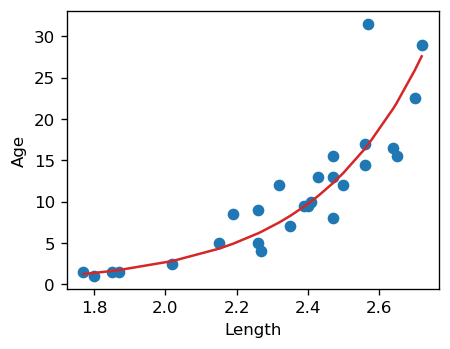

In [40]:
#| code-fold: true
plt.figure(dpi=120, figsize=(4, 3))

plt.scatter(x, y)
plt.plot(x, np.exp(theta_0)*np.exp(theta_1*x), "tab:red")
plt.xlabel("Length")
plt.ylabel("Age");

You may wonder: why did we choose to apply a log transformation specifically? Why not some other function to linearize the data?

Practically, many other mathematical operations that modify the relative scales of `"Age"` and `"Length"` could have worked here.


## Notation for Multiple Linear Regression

### Terminology
There are several equivalent terms in the context of regression. The ones we use most often for this course are bolded. 
* $x$ can be called a
    * **Feature(s)**
    * Covariate(s)
    * **Independent variable(s)**
    * Explanatory variable(s)
    * Predictor(s)
    * Input(s)
    * Regressor(s)
* $y$ can be called an
    * **Output**
    * Outcome
    * **Response**
    * Dependent variable
* $\hat{y}$ can be called a
    * **Prediction**
    * Predicted response
    * Estimated value
* $\theta$ can be called a
    * **Weight(s)**
    * **Parameter(s)**
    * Coefficient(s)
* $hat{\theta}$ can be called a
    * **Estimator(s)**
    * **Optimal parameter(s)**
* A datapoint $(x, y)$ is also called an **observation**.

### Multiple Linear Regression Model
Define the multiple linear regression model:
